<a href="https://colab.research.google.com/github/alexk2206/Data_Driven_Fantasy_Football/blob/dev/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [108]:
year = 2020
MIP_dfs = []
for run in range(1, 6):
    url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/main/simulations/MIP/simulation_results_MIP_ALL_{year}_run{run}.json"
    df = pd.read_json(url)
    df["Run"] = run
    MIP_dfs.append(df)

MIP_sim = pd.concat(MIP_dfs, ignore_index=True)
print(len(MIP_sim))
print(MIP_sim.head())

500
   Simulation   Winner  DM-Team  DM-Team-Win  DM-Placement   Record  \
0           1   Team 8   Team 3        False            11  [4, 10]   
1           2   Team 6   Team 1        False            11   [5, 9]   
2           3  Team 11   Team 4        False            10   [5, 9]   
3           4   Team 9   Team 4        False            10   [5, 9]   
4           5  Team 12  Team 10        False            11   [5, 9]   

   DM-Points-Regular-Season  DM-Points-Playoffs  \
0                   1049.36                 0.0   
1                   1046.14                 0.0   
2                   1137.74                 0.0   
3                   1024.26                 0.0   
4                   1069.14                 0.0   

                      Opp_Team_Points_Regular_Season  \
0  {'Team 1': 1195.8, 'Team 2': 1124.38, 'Team 3'...   
1  {'Team 1': 1046.14, 'Team 2': 1207.1, 'Team 3'...   
2  {'Team 1': 1161.64, 'Team 2': 1399.12, 'Team 3...   
3  {'Team 1': 1163.8, 'Team 2': 1305.4

In [109]:
# year = 2024
if year == 2024:
    ADP_dfs = []
    for run in range(1, 2):
        url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/simulations/ADP/simulation_results_ADP_ALL_{year}_run{run}.json"
        df = pd.read_json(url)
        df["Run"] = run
        ADP_dfs.append(df)

    ADP_sim = (
        pd.concat(ADP_dfs, ignore_index=True)
    )
    print(len(ADP_sim))
    print(ADP_sim.head())
else:
    ADP_dfs = []
    for run in range(1, 11):
        url = f"https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/simulations/ADP/simulation_results_ADP_{run}_{year}.json"
        df = pd.read_json(url)
        df["Run"] = run
        ADP_dfs.append(df)

    ADP_sim = (
        pd.concat(ADP_dfs, ignore_index=True)
    )
    print(len(ADP_sim))
    print(ADP_sim.head())

HTTPError: HTTP Error 404: Not Found

# Vergleich Winrates pro Startplatz

    Draftslot  ADP_Winrate  MIP_Winrate
0           1        0.044     0.000000
1           2        0.032     0.000000
2           3        0.036     0.000000
3           4        0.104     0.035088
4           5        0.120     0.000000
5           6        0.150     0.000000
6           7        0.080     0.026316
7           8        0.082     0.000000
8           9        0.066     0.000000
9          10        0.096     0.000000
10         11        0.120     0.000000
11         12        0.070     0.000000


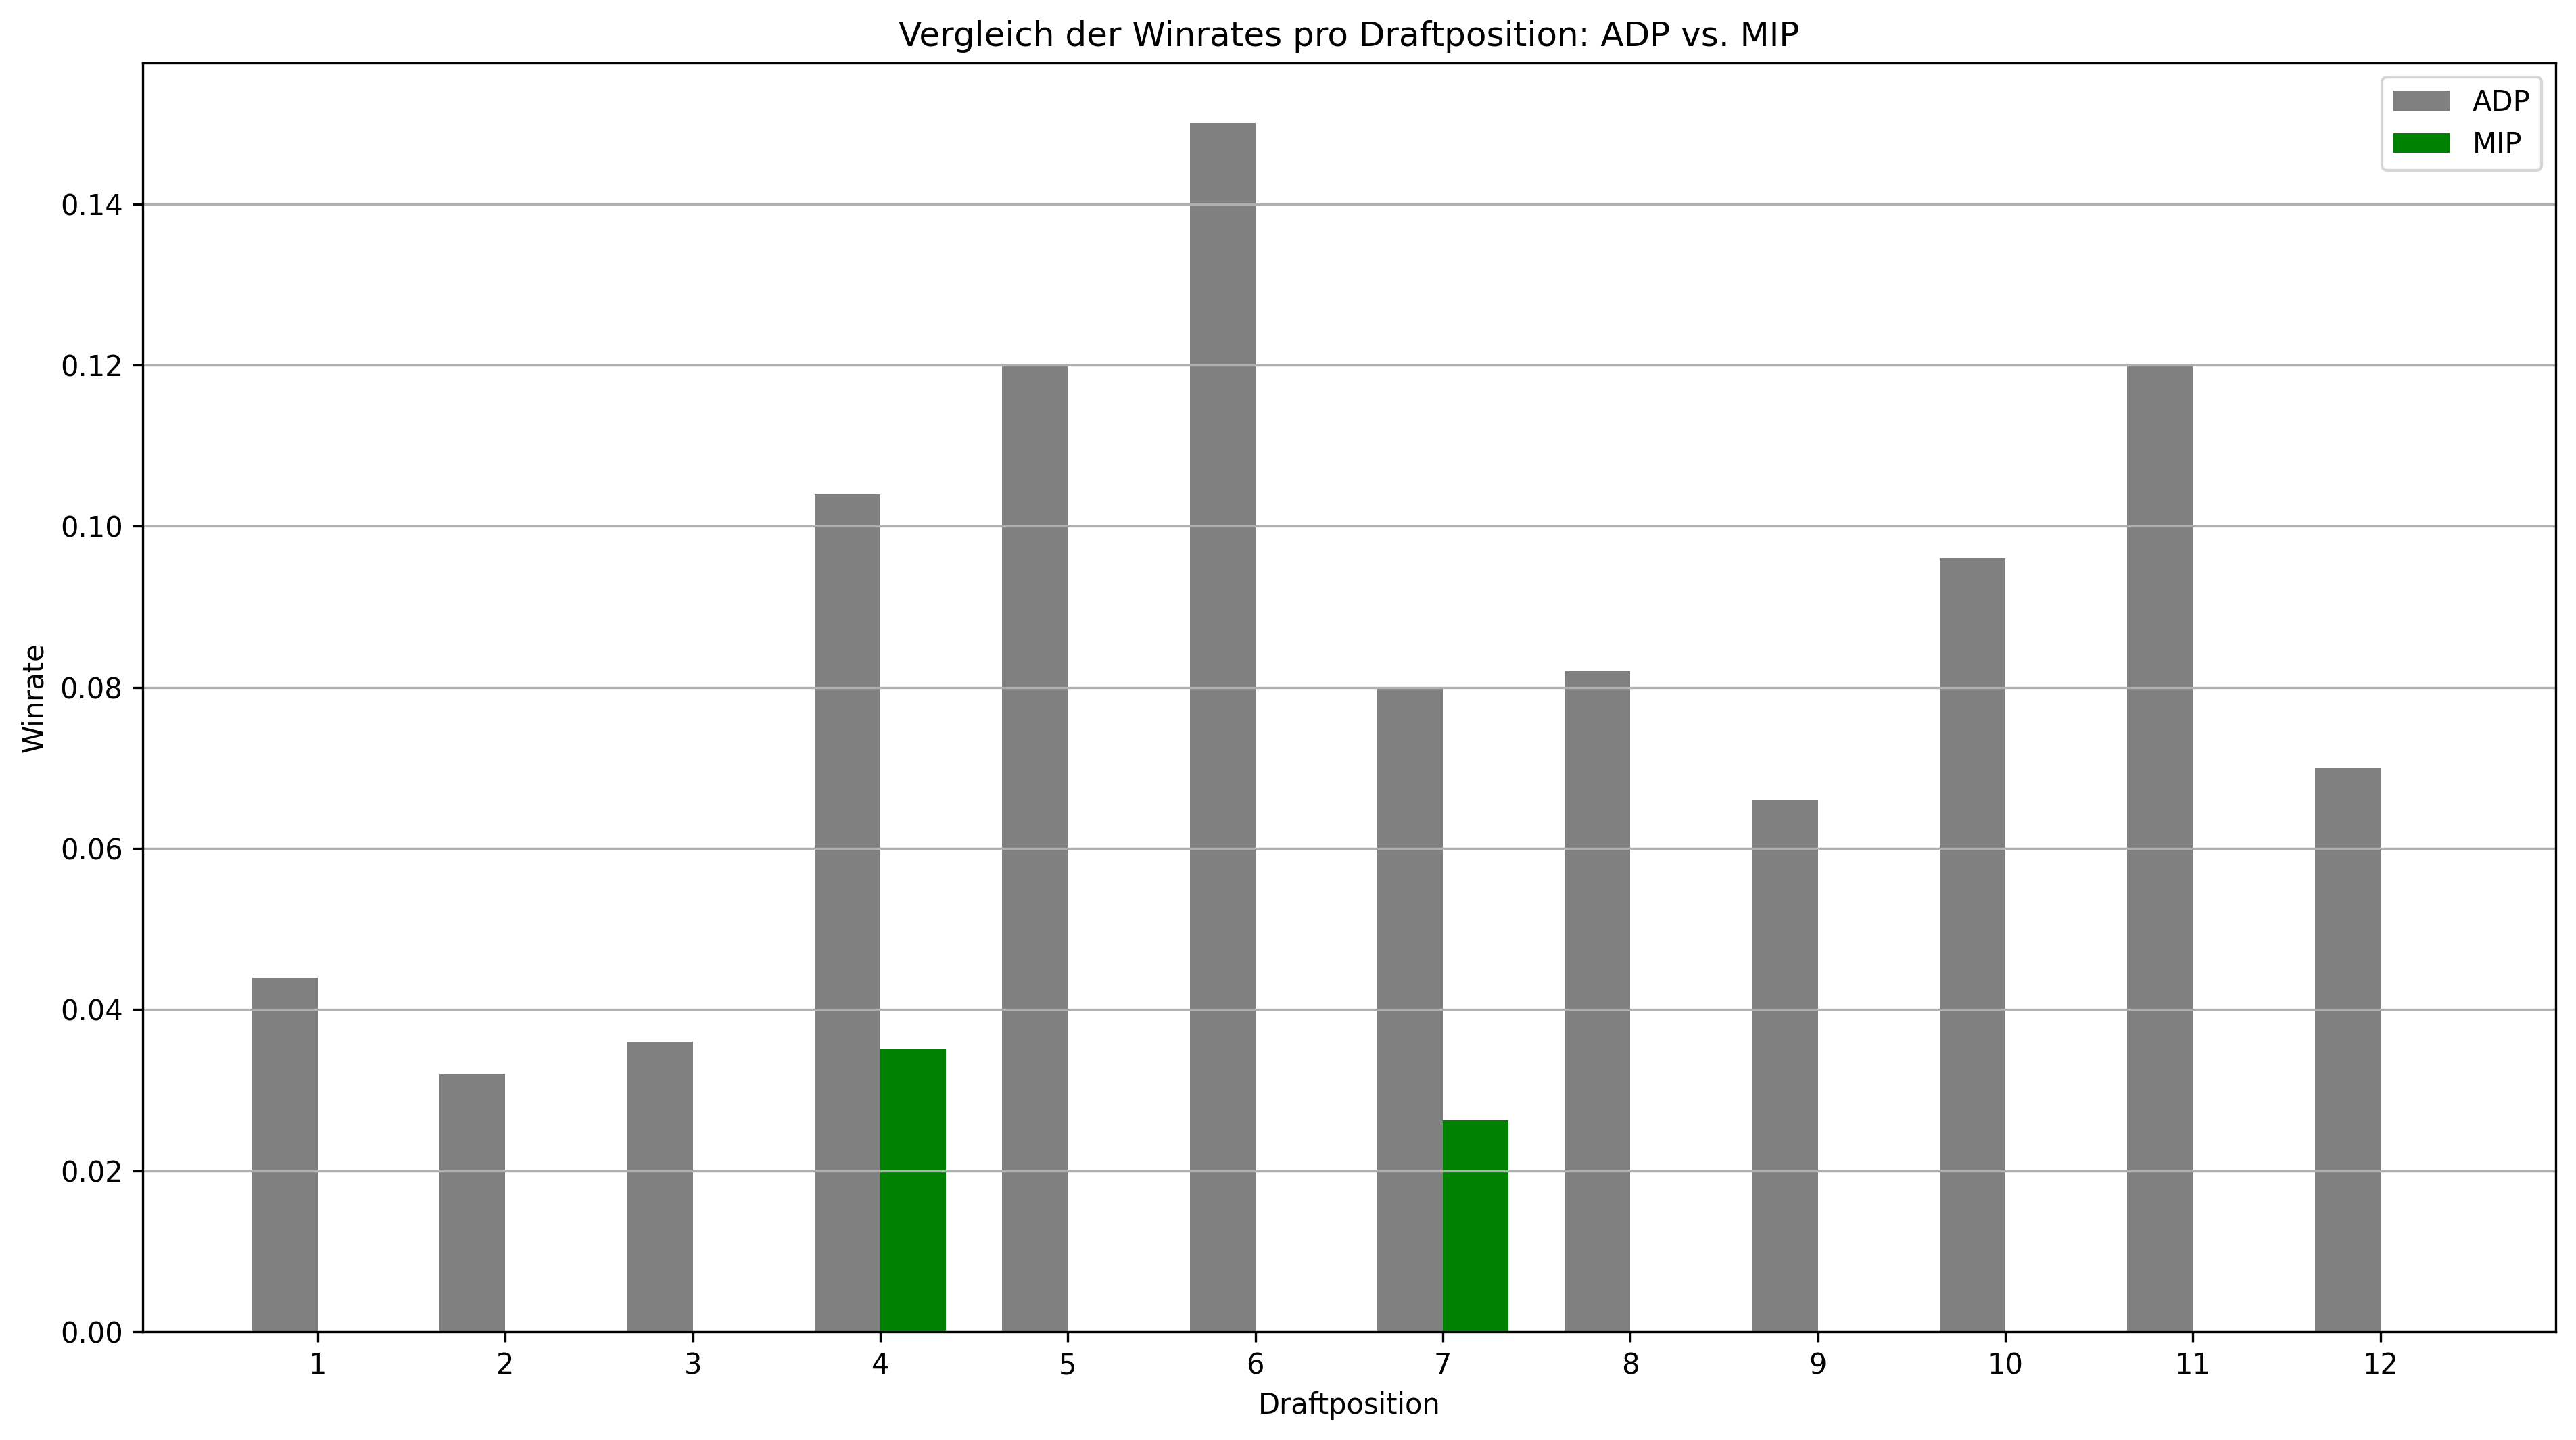

In [78]:
ADP_sim["Draftslot"] = ADP_sim["Winner"].str.extract(r"(\d+)").astype(int)

ADP_winrate_df = (
    ADP_sim.groupby("Draftslot")
    .size()
    .rename("Wins")
    .reset_index()
)

total_sims = len(ADP_sim)
ADP_winrate_df["Simulations"] = total_sims
ADP_winrate_df["Winrate"] = ADP_winrate_df["Wins"] / total_sims

# print(ADP_winrate_df)

# Draftslot aus DM-Team extrahieren
MIP_sim["Draftslot"] = MIP_sim["DM-Team"].str.extract(r"(\d+)").astype(int)

# Filter: Nur gewonnene DM-Simulationen
winners_only = MIP_sim[MIP_sim["DM-Team-Win"] == True].copy()

# Gruppierung: Siege pro Draftslot
win_counts = winners_only["Draftslot"].value_counts().sort_index()

# Alle Simulationen pro Slot (auch verlorene) zählen
total_counts = MIP_sim["Draftslot"].value_counts().sort_index()

# DataFrame erstellen
MIP_winrate_df = (
    pd.DataFrame({
        "Wins": win_counts,
        "Simulations": total_counts
    })
    .fillna(0)
    .astype(int)
    .assign(Winrate=lambda df: df["Wins"] / df["Simulations"])
    .reset_index()
    .rename(columns={"index": "Draftslot"})
    .sort_values("Draftslot")
)

# print(MIP_winrate_df)


# Plot

# Umbenennen der Winrate-Spalten zur Unterscheidung
ADP_df = ADP_winrate_df[["Draftslot", "Winrate"]].rename(columns={"Winrate": "ADP_Winrate"})
MIP_df = MIP_winrate_df[["Draftslot", "Winrate"]].rename(columns={"Winrate": "MIP_Winrate"})

# Zusammenführen
compare_df = pd.merge(ADP_df, MIP_df, on="Draftslot").sort_values("Draftslot")
print(compare_df)

# Balkendiagramm
x = compare_df["Draftslot"]
width = 0.35

fig, ax = plt.subplots(figsize=(3840 / 300, 2160 / 300), dpi=300)
ax.bar(x - width/2, compare_df["ADP_Winrate"], width, label="ADP", color="gray")
ax.bar(x + width/2, compare_df["MIP_Winrate"], width, label="MIP", color="green")

# Layout
ax.set_xlabel("Draftposition")
ax.set_ylabel("Winrate")
ax.set_title("Vergleich der Winrates pro Draftposition: ADP vs. MIP")
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

fig.savefig(f"winrate_comparison_{year}.png")

    Placement  Count  Relative
0           1      3     0.006
1           2      2     0.004
2           3     11     0.022
3           4     10     0.020
4           5     18     0.036
5           6      8     0.016
6           7     19     0.038
7           8     44     0.088
8           9     44     0.088
9          10     86     0.172
10         11     97     0.194
11         12    158     0.316


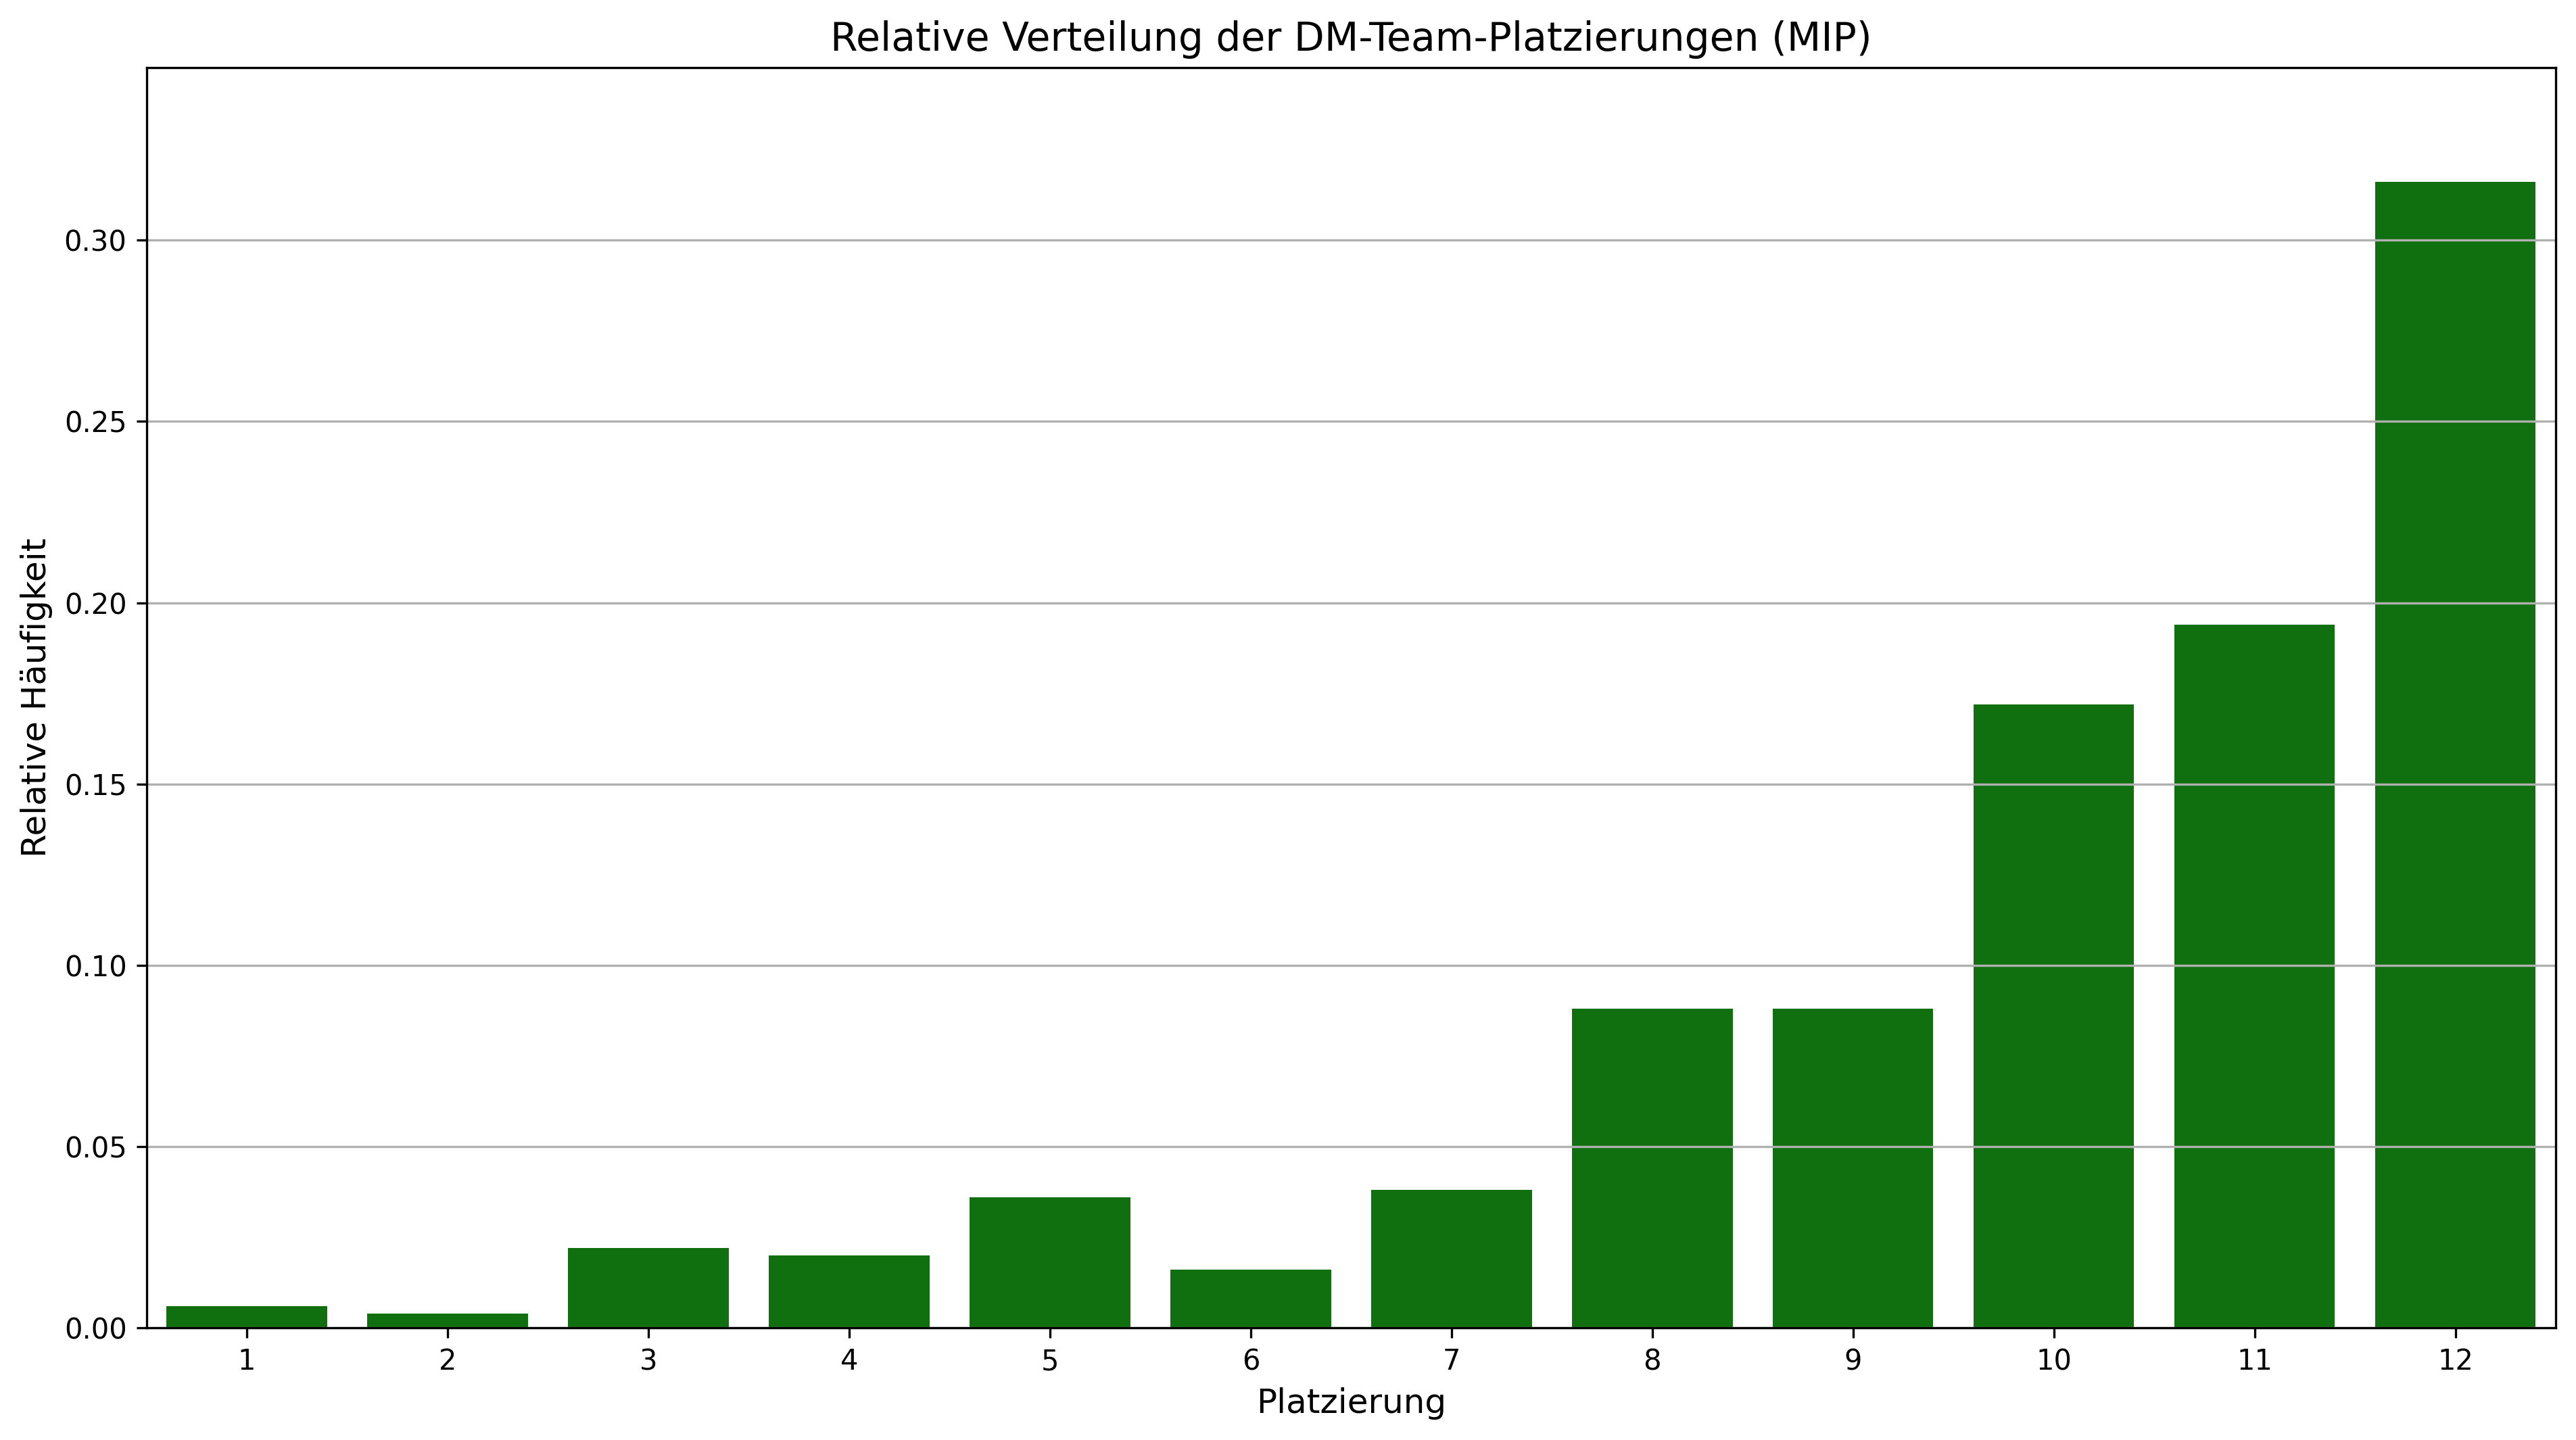

In [79]:
# Absolute Platzierungsverteilung
placement_counts = (
    MIP_sim["DM-Placement"]
    .value_counts()
    .sort_index()
    .rename_axis("Placement")
    .reset_index(name="Count")
)

# Umwandlung in relative Häufigkeiten
total_simulations = len(MIP_sim)
placement_counts["Relative"] = placement_counts["Count"] / total_simulations

# Ausgabe-DataFrame zur weiteren Auswertung
placement_rel_df = placement_counts.copy()
print(placement_rel_df)

# Plot der relativen Werte
fig, ax = plt.subplots(figsize=(3840 / 300, 2160 / 300), dpi=300)
sns.barplot(data=placement_rel_df, x="Placement", y="Relative", color="green", ax=ax)

# Layout
ax.set_title("Relative Verteilung der DM-Team-Platzierungen (MIP)", fontsize=14)
ax.set_xlabel("Platzierung", fontsize=12)
ax.set_ylabel("Relative Häufigkeit", fontsize=12)
ax.set_ylim(0, placement_rel_df["Relative"].max() * 1.1)
ax.grid(True, axis='y')
plt.tight_layout()

# Anzeigen und Speichern
plt.show()
fig.savefig(f"dm_placement_distribution_relative_MIP_{year}.png")


In [125]:
import pandas as pd
import ast

real_data_FP_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/Weekly_Data/FantasyPros_Fantasy_Football_Points_PPR_{year}.csv'
real_data_FP = (
    pd.read_csv(real_data_FP_url)
      .rename(columns={'player_display_name': 'Player'})
      .replace({'-': 0, 'BYE': 0})
      .drop(columns = ['#', 'Team'], errors='ignore')
      .loc[:, ['Player', 'TTL']]
)

import pandas as pd
import ast
import re

def analyze_all_picks(MIP_sim: pd.DataFrame) -> pd.DataFrame:
    player_picks = []

    for picks_raw in MIP_sim["DM-Picks"]:
        picks = ast.literal_eval(picks_raw) if isinstance(picks_raw, str) else picks_raw
        for pick in picks:
            match = re.match(r"^(.*) \(Pick (\d+)\)$", pick)
            if match:
                player = match.group(1).strip()
                pick_number = int(match.group(2))
                player_picks.append((player, pick_number))

    df_picks = pd.DataFrame(player_picks, columns=["Player", "Pick"])

    pick_summary = (
        df_picks
        .groupby("Player")
        .agg(
            Times_Drafted=("Pick", "count"),
            Average_Pick=("Pick", "mean")
        )
        .sort_values(by="Times_Drafted", ascending=False)
        .reset_index()
    )

    return pick_summary



In [140]:
#filter real_data_FP for Aaron Jones
real_data_FP_url = f'https://raw.githubusercontent.com/alexk2206/Data_Driven_Fantasy_Football/refs/heads/main/Weekly_Data/FantasyPros_Fantasy_Football_Points_PPR_{year}.csv'
real_data_FP = (
    pd.read_csv(real_data_FP_url)
      .rename(columns={'player_display_name': 'Player'})
      .replace({'-': 0, 'BYE': 0})
      .drop(columns = ['#', 'Team'], errors='ignore')
      .loc[:, ['Player', 'TTL']]
)

num_teams = 12
adp_cutoff = num_teams * 5

def analyze_all_picks(MIP_sim: pd.DataFrame) -> pd.DataFrame:
    player_picks = []

    for picks_raw in MIP_sim["DM-Picks"]:
        picks = ast.literal_eval(picks_raw) if isinstance(picks_raw, str) else picks_raw
        for pick in picks:
            match = re.match(r"^(.*) \(Pick (\d+)\)$", pick)
            if match:
                player = match.group(1).strip()
                pick_number = int(match.group(2))
                player_picks.append((player, pick_number))

    df_picks = pd.DataFrame(player_picks, columns=["Player", "Pick"])

    pick_summary = (
        df_picks
        .groupby("Player")
        .agg(
            Times_Drafted=("Pick", "count"),
            ADP=("Pick", "mean")
        )
        .sort_values(by="ADP", ascending=True)
        .reset_index()
        .merge(real_data_FP, on="Player", how="left")
    )

    return pick_summary
df_pick_stats = analyze_all_picks(MIP_sim)
df_pick_stats = df_pick_stats[df_pick_stats['ADP'] <= adp_cutoff].copy()
display(df_pick_stats)

,Player,Times_Drafted,ADP,TTL
0,Dalvin Cook,218,3.174312,337.8
1,Joe Mixon,212,7.877358,99.6
2,Derrick Henry,171,15.456140,333.1
3,Aaron Jones,181,18.016575,258.9
4,James Conner,79,21.632911,164.6
5,Odell Beckham,138,22.710145,86.8
6,Miles Sanders,152,27.072368,170.4
7,Mike Evans,79,29.670886,248.6
8,David Johnson,233,33.124464,179.5
9,LeVeon Bell,92,37.369565,74.6


In [129]:
MIP_sim

,Simulation,Winner,DM-Team,DM-Team-Win,DM-Placement,Record,DM-Points-Regular-Season,DM-Points-Playoffs,Opp_Team_Points_Regular_Season,Opp_Team_Points_Playoffs,DM-Picks,Run
0,1,Team 8,Team 3,False,11,"[4, 10]",1049.36,0.0,"{'Team 1': 1195.8, 'Team 2': 1124.38, 'Team 3'...","{'Team 8': 348.08, 'Team 11': 310.18, 'Team 7'...","[Dalvin Cook (Pick 3), Odell Beckham (Pick 22)...",1
1,2,Team 6,Team 1,False,11,"[5, 9]",1046.14,0.0,"{'Team 1': 1046.14, 'Team 2': 1207.1, 'Team 3'...","{'Team 6': 279.98, 'Team 11': 308.78, 'Team 12...","[Dalvin Cook (Pick 1), LeVeon Bell (Pick 24), ...",1
2,3,Team 11,Team 4,False,10,"[5, 9]",1137.74,0.0,"{'Team 1': 1161.64, 'Team 2': 1399.12, 'Team 3...","{'Team 11': 299.48, 'Team 5': 317.98, 'Team 7'...","[Dalvin Cook (Pick 4), Aaron Jones (Pick 21), ...",1
3,4,Team 9,Team 4,False,10,"[5, 9]",1024.26,0.0,"{'Team 1': 1163.8, 'Team 2': 1305.4, 'Team 3':...","{'Team 9': 305.88, 'Team 10': 355.86, 'Team 6'...","[Dalvin Cook (Pick 4), Odell Beckham (Pick 21)...",1
4,5,Team 12,Team 10,False,11,"[5, 9]",1069.14,0.0,"{'Team 1': 1125.94, 'Team 2': 1185.66, 'Team 3...","{'Team 12': 354.76, 'Team 2': 320.56, 'Team 7'...","[Derrick Henry (Pick 10), Aaron Jones (Pick 15...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
495,396,Team 7,Team 1,False,12,"[0, 14]",876.06,0.0,"{'Team 1': 876.06, 'Team 2': 1242.3, 'Team 3':...","{'Team 7': 305.18, 'Team 11': 399.0, 'Team 6':...","[Dalvin Cook (Pick 1), Miles Sanders (Pick 24)...",5
496,397,Team 10,Team 2,False,5,"[8, 6]",1184.64,0.0,"{'Team 1': 1153.8, 'Team 2': 1184.64, 'Team 3'...","{'Team 10': 354.76, 'Team 3': 282.08, 'Team 4'...","[Dalvin Cook (Pick 2), Aaron Jones (Pick 23), ...",5
497,398,Team 9,Team 7,False,11,"[5, 9]",1036.74,0.0,"{'Team 1': 1189.7, 'Team 2': 1028.14, 'Team 3'...","{'Team 9': 254.68, 'Team 10': 331.58, 'Team 5'...","[Joe Mixon (Pick 7), Aaron Jones (Pick 18), Am...",5
498,399,Team 8,Team 1,False,11,"[4, 10]",981.56,0.0,"{'Team 1': 981.56, 'Team 2': 1134.74, 'Team 3'...","{'Team 8': 440.6, 'Team 7': 249.28, 'Team 4': ...","[Dalvin Cook (Pick 1), Odell Beckham (Pick 24)...",5


In [134]:
real_data_FP.head(5)

,Player,TTL
0,Josh Allen,406.1
1,Kyler Murray,390.7
2,Aaron Rodgers,388.3
3,Patrick Mahomes II,380.4
4,Alvin Kamara,377.8
